In [30]:
!ls ../input/planets-dataset/planet/planet/train-jpg | wc -l

40479


In [31]:
!ls ../input/planets-dataset/planet/planet/test-jpg | wc -l


40669


In [32]:
# Libraries for Loading and Preparing dataset
from os import listdir
from numpy import zeros
from numpy import asarray
from numpy import savez_compressed
from pandas import read_csv
from tensorflow.keras import backend
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
import os
import time
from sklearn.metrics import fbeta_score
import tensorflow as tf
from tensorflow.keras.optimizers import SGD
import sys

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, BatchNormalization, Conv2D, MaxPooling2D,Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model

In [33]:
# Libraries for Data Visualisation
import matplotlib.pyplot as plt
from matplotlib import pyplot
from matplotlib.image import imread
%matplotlib inline

In [34]:
# Imporing Required Libraries
import pandas as pd
import numpy as np

In [35]:
data_path = "../input/planets-dataset/planet/planet"
train_dataset = pd.read_csv(data_path+"/train_classes.csv")
test_image_dataset = data_path + "/test-jpg/"
train_image_dataset = data_path + "/train-jpg/"


In [36]:
train_dataset.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


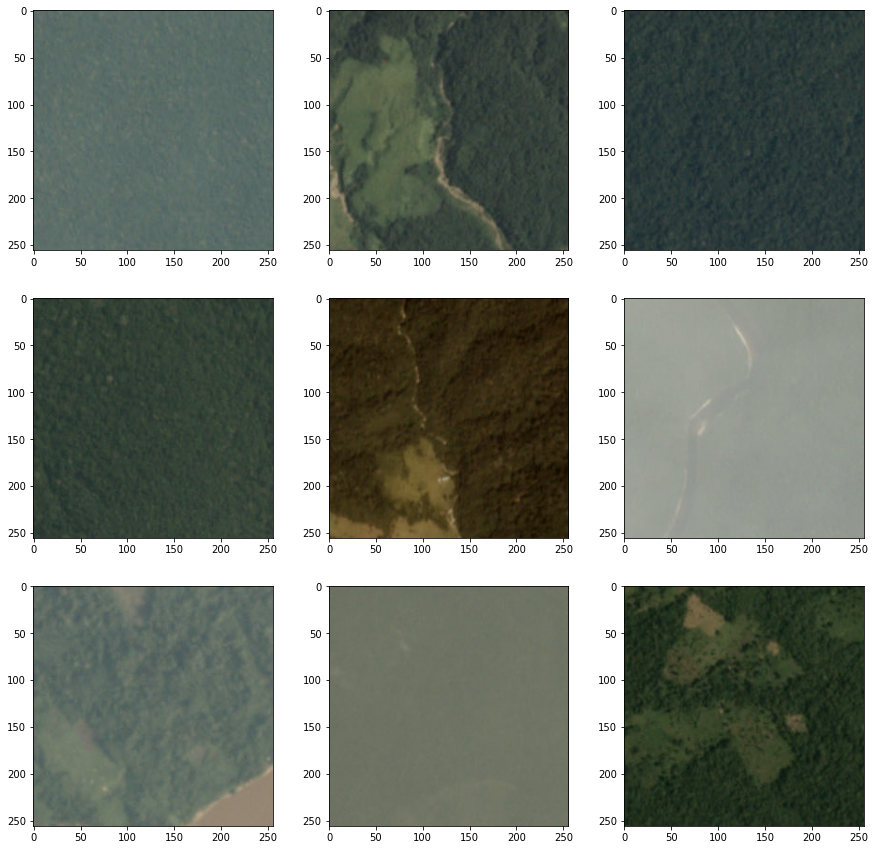

In [37]:
#View train Images
plt.figure(figsize=(15,15))
folder = data_path + "/train-jpg/"
for i in range(9):
    pyplot.subplot(330 + 1 + i)
    
    #Defining the file
    file = train_image_dataset + 'train_' + str(i) + '.jpg'
    
    #Load pixels of the images
    images = imread(file)
    
    #Plot the pixel images data
    pyplot.imshow(images)
    
plt.show()

In [38]:
# Removal of tags separated with a space, by splitting the spaces in the train_dataset
dataset_list = []
for tag in train_dataset.tags.values:
    dataset = tag.split(' ')
    for data in dataset:
        if data not in dataset_list:
            dataset_list.append(data)
            
len(dataset_list)


17

In [39]:
dataset_list.sort()

In [40]:
#Creating a tag dataset map
tag_mappings = {dataset_list[i]: i for i in range(len(dataset_list))}
tag_mappings

{'agriculture': 0,
 'artisinal_mine': 1,
 'bare_ground': 2,
 'blooming': 3,
 'blow_down': 4,
 'clear': 5,
 'cloudy': 6,
 'conventional_mine': 7,
 'cultivation': 8,
 'habitation': 9,
 'haze': 10,
 'partly_cloudy': 11,
 'primary': 12,
 'road': 13,
 'selective_logging': 14,
 'slash_burn': 15,
 'water': 16}

In [41]:
#Creating a tag dataset map
inverse_datasets_map = {i:dataset_list[i] for i in range(len(dataset_list))}
inverse_datasets_map

{0: 'agriculture',
 1: 'artisinal_mine',
 2: 'bare_ground',
 3: 'blooming',
 4: 'blow_down',
 5: 'clear',
 6: 'cloudy',
 7: 'conventional_mine',
 8: 'cultivation',
 9: 'habitation',
 10: 'haze',
 11: 'partly_cloudy',
 12: 'primary',
 13: 'road',
 14: 'selective_logging',
 15: 'slash_burn',
 16: 'water'}

In [42]:
# Map files to tags
def file_mapper(data_csv):
    mapper = dict()
    for i in range(len(data_csv)):
        name, tags = data_csv['image_name'][i], data_csv['tags'][i]
        mapper[name] = tags.split(' ')
    return mapper
    
mapped_file = file_mapper(train_dataset)
#mapped_file

In [43]:
#Create a one hot encoding for the tags
def one_hot_encoder(tags, mapper):
    
    #Creating an empty matrix(Vector)
    encoding = np.zeros(len(mapper), dtype='uint8')
    
    #Map 1 for each tag in the vector created
    for t in tags:
        encoding[mapper[t]] = 1
    return encoding

In [44]:
#Preparation of the image data
def load_dataset(path, file_mapping, tag_mapping):
    photos = list()
    targets = list()
    
    #For files in the image directory
    for file in os.listdir(train_image_dataset):
        
        #Load Images
        photo = load_img(path + file, target_size = (64, 64))
        
        #Converting photos to numpy array
        photo = img_to_array(photo, dtype = 'uint8')
        
        #Tags
        tags = mapped_file[file[:-4]]
        
        #OHE of Tags
        target = one_hot_encoder(tags, tag_mapping)
        
        #Stores
        photos.append(photo)
        targets.append(target)
    X = np.asarray(photos,dtype='uint8')
    Y = np.asarray(targets,dtype='uint8')
    return X,Y

X, Y = load_dataset(train_image_dataset, mapped_file, tag_mappings)
print(X.shape, Y.shape)

# Compressing X and Y arrays into one single file
np.savez_compressed('planet_data.npz', X, Y)

(40479, 64, 64, 3) (40479, 17)


In [45]:
#Loading the Dataset
dataset = np.load('./planet_data.npz')
X, Y = dataset['arr_0'], dataset['arr_1']
print(X.shape)
print(Y.shape)

(40479, 64, 64, 3)
(40479, 17)


In [46]:
# Libraries for train-test-split
from sklearn.model_selection import train_test_split

In [47]:
#Split Into training and Validation set
X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size = 0.3, random_state = 123)
print("X_train shape : ", X_train.shape)
print("y_train shape : ", y_train.shape)
print("X_val shape", X_val.shape)
print("y_val shape : ", y_val.shape)

X_train shape :  (28335, 64, 64, 3)
y_train shape :  (28335, 17)
X_val shape (12144, 64, 64, 3)
y_val shape :  (12144, 17)


**Base Model**

In [48]:
# test f-beta score
from numpy import load
from numpy import ones
from numpy import asarray
from sklearn.model_selection import train_test_split
from sklearn.metrics import fbeta_score

In [49]:
train_yhat = asarray([ones(y_train.shape[1]) for _ in range(y_train.shape[0])])
val_yhat = asarray([ones(y_val.shape[1]) for _ in range(y_val.shape[0])])

#Evaluate Predictions
train_score = fbeta_score(y_train, train_yhat, average='samples', beta=2)
test_score = fbeta_score(y_val, val_yhat, average='samples', beta=2)

print('All Ones: train=%.3f, test=%.3f' % (train_score, test_score))

All Ones: train=0.483, test=0.485


In [50]:
from tensorflow.keras import backend

#Calculating fbeta for multi-class/label classification
def fbeta(y_true, y_pred, beta=2):
    y_pred = backend.clip(y_pred, 0, 1)
    #Calculate TP, FP and FN
    tp = backend.sum(backend.round(backend.clip(y_true * y_pred, 0, 1)), axis=1)
    fp = backend.sum(backend.round(backend.clip(y_pred - y_true, 0, 1)), axis=1)
    fn = backend.sum(backend.round(backend.clip(y_true - y_pred, 0, 1)), axis=1)
    
    #Calculate Precision
    p = tp / (tp + fp + backend.epsilon())
    
    #Calculae Recall
    r = tp / (tp + fn + backend.epsilon())
    
    #Calculate fbeta, averaged across each class
    bb = beta ** 2
    fbeta_score = backend.mean((1 + bb)* (p * r)/ (bb * p + r + backend.epsilon()))
    return fbeta_score

In [51]:
#Evaluate predictions with keras
train_score = fbeta(backend.variable(y_train), backend.variable(train_yhat))
test_score = fbeta(backend.variable(y_val), backend.variable(val_yhat))

print('All Ones (keras): train=%.3f, test=%.3f' % (train_score, test_score))

All Ones (keras): train=0.483, test=0.485


In [52]:
model = Sequential()
#A convolution is used to extract features such as colors edges orientation from input images
#The Activation function introduces non linearity
model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(64, 64, 3)))
model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
#Pooling layer carrie out dimensionality reduction (Downsampling)
#Reduces Overfitting, Increases training speed
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3,3), activation='relu', kernel_initializer='he_uniform', padding ='same'))
model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3,3), activation='relu', kernel_initializer='he_uniform', padding ='same'))
model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(MaxPooling2D((2, 2)))

#Max pooling gives a feature map
#Flattening is converting the data into a 1-dimensional array for inputting it to the next layer.(Feature Vector)
#Dense layer expects a 1 Dimension array
model.add(Flatten())
model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(17, activation='sigmoid'))

#Compile Model
opt = SGD(learning_rate=0.01, momentum=0.9)
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=[fbeta])

In [53]:
#Create a data Generator
datagen = ImageDataGenerator(rescale=1.0/255.0)
#Prepare Iterators
train_it = datagen.flow(X_train, y_train, batch_size = 128)
test_it = datagen.flow(X_val, y_val, batch_size=128)

In [54]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 64, 64, 32)        896       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 64, 64, 32)        9248      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 32, 32, 64)        36928     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 16, 16, 128)      

In [55]:
#fit model
#The fit_generator() function called to fit the model returns a dictionary containing the loss and F-beta scores recorded each epoch on the train and test dataset.
history = model.fit(train_it, steps_per_epoch=len(train_it), validation_data=test_it, validation_steps=len(test_it), epochs=20, verbose=1)


Epoch 1/20
222/222 [==============================] - 7s 28ms/step - loss: 0.2462 - fbeta: 0.6307 - val_loss: 0.2154 - val_fbeta: 0.6804
Epoch 2/20
222/222 [==============================] - 6s 28ms/step - loss: 0.2095 - fbeta: 0.6886 - val_loss: 0.1943 - val_fbeta: 0.7165
Epoch 3/20
222/222 [==============================] - 6s 29ms/step - loss: 0.1973 - fbeta: 0.7208 - val_loss: 0.1889 - val_fbeta: 0.7363
Epoch 4/20
222/222 [==============================] - 6s 27ms/step - loss: 0.1876 - fbeta: 0.7414 - val_loss: 0.1872 - val_fbeta: 0.7365
Epoch 5/20
222/222 [==============================] - 7s 29ms/step - loss: 0.1804 - fbeta: 0.7562 - val_loss: 0.1765 - val_fbeta: 0.7734
Epoch 6/20
222/222 [==============================] - 6s 27ms/step - loss: 0.1752 - fbeta: 0.7628 - val_loss: 0.1746 - val_fbeta: 0.7565
Epoch 7/20
222/222 [==============================] - 6s 28ms/step - loss: 0.1691 - fbeta: 0.7741 - val_loss: 0.1615 - val_fbeta: 0.7902
Epoch 8/20
222/222 [=====================

In [56]:
file = train_image_dataset + 'train_' + str(0) + '.jpg'
file

'../input/planets-dataset/planet/planet/train-jpg/train_0.jpg'

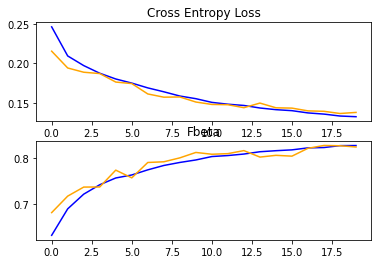

In [57]:
#Plot diagnostic learning curves
def summarize_diagnistics(history):
    #Plot loss
    pyplot.subplot(211)
    pyplot.title("Cross Entropy Loss")
    pyplot.plot(history.history['loss'], color='blue', label='train')
    pyplot.plot(history.history['val_loss'], color='orange', label='test')
    
    #Plot accuracy
    pyplot.subplot(212)
    pyplot.title('Fbeta')
    pyplot.plot(history.history['fbeta'], color='blue', label='train')
    pyplot.plot(history.history['val_fbeta'], color = 'orange', label='test')
    
    #Save plot to file
    filename = sys.argv[0].split('/')[-1]
    pyplot.savefig(filename + '_plot.png')
    #pyplot.close()
    pyplot.show()
    
summarize_diagnistics(history)

In [58]:
#function to prepare the image for prediction
def load_image(filename):
    # load the image
    img = load_img(filename, target_size=(64, 64))
    # convert to array
    img = img_to_array(img)
    # reshape into a single sample with 3 channels
    img = img.reshape(1, 64, 64, 3)
    # center pixel data
    img = np.asarray(img,dtype='uint8')
    img = img - [123.68, 116.779, 103.939]
    return img

In [59]:
file = train_image_dataset + 'train_' + str(0) + '.jpg'
file

'../input/planets-dataset/planet/planet/train-jpg/train_0.jpg'

In [60]:
img = load_image(file)
result = model.predict(img)
result
result.round()

array([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0.,
        0.]], dtype=float32)

In [61]:
def run_example(inv_mapping):
    # load the image
    img = load_image(file)
    # load model
    # predict the class
    result = model.predict(img)
    print(result[0])
    # map prediction to tags
    tags = prediction_to_tags(inv_mapping, result[0])
    print(tags)

In [62]:
def prediction_to_tags(inv_mapping, prediction):
    # round probabilities to {0, 1}
    values = prediction.round()
    # collect all predicted tags
    tags = [inv_mapping[i] for i in range(len(values)) if values[i] == 1.0]
    return tags

In [63]:
def create_tag_mapping(train_dataset):
    # create a set of all known tags
    labels = set()
    for i in range(len(train_dataset)):
        # convert spaced separated tags into an array of tags
        tags = train_dataset['tags'][i].split(' ')
        # add tags to the set of known labels
        labels.update(tags)
    # convert set of labels to a list to list
    labels = list(labels)
    # order set alphabetically
    labels.sort()
    # dict that maps labels to integers, and the reverse
    labels_map = {labels[i]:i for i in range(len(labels))}
    inv_labels_map = {i:labels[i] for i in range(len(labels))}
    return labels_map, inv_labels_map
_, inv_mapping = create_tag_mapping(train_dataset)
run_example(inv_mapping)

[0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0.]
['clear', 'primary', 'road']


In [64]:
#saving the model
import os.path
if os.path.isfile('planet_model.h5') is False:
    model.save('planet_model.h5')

In [65]:
#setting dependencie to use the fbeta metric while loading the saved model
dependencies = {
     'fbeta': fbeta
}

In [66]:
#loading the model
from tensorflow.keras.models import load_model
model = load_model('planet_model.h5', custom_objects=dependencies)

In [67]:
#printing the weights of the model
model.get_weights()


[array([[[[ 2.51794219e-01, -4.62092578e-01,  4.66714799e-01,
            8.17043409e-02,  2.92133510e-01,  4.72127553e-03,
           -4.15031731e-01,  2.04273075e-01,  3.99069399e-01,
           -2.47555584e-01, -5.05633175e-01,  4.72512156e-01,
           -5.07701337e-01,  2.03915164e-01,  3.98391068e-01,
            2.57121414e-01,  2.59718418e-01,  6.16359487e-02,
           -1.03844792e-01,  9.30257663e-02, -2.10737556e-01,
           -4.64286417e-01, -3.63950402e-01,  2.06305102e-01,
            3.58246535e-01, -2.92045951e-01, -3.95897239e-01,
            8.83892700e-02, -4.36135918e-01,  1.07570648e-01,
           -3.59896570e-01, -5.57529181e-02],
          [ 2.60060519e-01,  1.02498226e-01,  2.44834021e-01,
            7.19224066e-02,  1.83003783e-01,  3.53480667e-01,
            1.12943603e-02, -3.01984131e-01,  4.25424427e-01,
           -3.31757665e-01,  3.54249626e-01, -3.10414076e-01,
            1.17591016e-01, -3.97223197e-02,  5.04049547e-02,
           -3.06697935e-

In [68]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 64, 64, 32)        896       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 64, 64, 32)        9248      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 32, 32, 64)        36928     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 16, 16, 128)      

**Prediction**

In [69]:
predictions = []

In [70]:
len(listdir(data_path + "/train-jpg/"))

40479

In [71]:
len(listdir(data_path + "/test-jpg/"))

40669

In [72]:
listdir(data_path + "/test-jpg/")[1]

'test_4849.jpg'

In [73]:
" ".join(['partly_cloudy', 'primary'])

'partly_cloudy primary'

In [74]:
listdir(data_path + "/test-jpg/")[i]

'test_16642.jpg'

In [75]:
(data_path + "/test-jpg/") + listdir(data_path + "/test-jpg/")[0]

'../input/planets-dataset/planet/planet/test-jpg/test_39140.jpg'

In [76]:
for i in range(len(listdir(data_path + "/test-jpg/"))):
    img = load_image((data_path + "/test-jpg/") + listdir(data_path + "/test-jpg/")[i])
    pred = model.predict(img)
    tags = prediction_to_tags(inv_mapping, pred[0])
    predictions.append(" ".join(tags))

In [77]:
predictions

['agriculture clear habitation primary road',
 'clear primary road',
 'agriculture clear habitation partly_cloudy primary road',
 'clear habitation primary road',
 'agriculture clear habitation primary road',
 'agriculture clear habitation primary road',
 'agriculture clear habitation primary road',
 'agriculture clear habitation primary road',
 'agriculture clear habitation primary road',
 'agriculture clear habitation primary road',
 'agriculture clear habitation primary road',
 'agriculture clear habitation primary road',
 'agriculture clear habitation primary road',
 'agriculture cultivation partly_cloudy primary road',
 'agriculture clear habitation primary road',
 'clear primary',
 'agriculture clear habitation primary road',
 'agriculture clear habitation primary road',
 'agriculture clear habitation primary road',
 'agriculture clear habitation primary road',
 'agriculture habitation partly_cloudy primary road',
 'agriculture clear habitation primary road',
 'clear primary',
 '

In [78]:
(predictions[0])

'agriculture clear habitation primary road'

In [79]:
df = pd.DataFrame()
df['tags'] = predictions

In [80]:
df.head(20)

,tags
0,agriculture clear habitation primary road
1,clear primary road
2,agriculture clear habitation partly_cloudy pri...
3,clear habitation primary road
4,agriculture clear habitation primary road
5,agriculture clear habitation primary road
6,agriculture clear habitation primary road
7,agriculture clear habitation primary road
8,agriculture clear habitation primary road
9,agriculture clear habitation primary road


In [81]:
df.isnull().sum()

tags    0
dtype: int64

In [82]:
df.shape

(40669, 1)

In [83]:
len(listdir(data_path + "/test-jpg/"))

40669

In [84]:
df['image_name'] = listdir(data_path + "/test-jpg/")

df

,tags,image_name
0,agriculture clear habitation primary road,test_39140.jpg
1,clear primary road,test_4849.jpg
2,agriculture clear habitation partly_cloudy pri...,test_18979.jpg
3,clear habitation primary road,test_24790.jpg
4,agriculture clear habitation primary road,test_30624.jpg
...,...,...
40664,clear habitation primary road,test_18830.jpg
40665,agriculture clear habitation primary road,test_16161.jpg
40666,agriculture clear habitation primary road,test_28240.jpg
40667,agriculture clear habitation primary road,test_880.jpg


In [85]:
submissions = pd.DataFrame()
submissions['image_name'] = listdir(data_path + "/test-jpg/")
submissions['tags'] = predictions
submissions


,image_name,tags
0,test_39140.jpg,agriculture clear habitation primary road
1,test_4849.jpg,clear primary road
2,test_18979.jpg,agriculture clear habitation partly_cloudy pri...
3,test_24790.jpg,clear habitation primary road
4,test_30624.jpg,agriculture clear habitation primary road
...,...,...
40664,test_18830.jpg,clear habitation primary road
40665,test_16161.jpg,agriculture clear habitation primary road
40666,test_28240.jpg,agriculture clear habitation primary road
40667,test_880.jpg,agriculture clear habitation primary road


In [86]:
data_path2 = '/kaggle/input/planets-dataset'

In [87]:
listdir(data_path2 + "/test-jpg-additional/test-jpg-additional/")[1]

'file_13422.jpg'

In [88]:
data_path2 = '/kaggle/input/planets-dataset'

In [89]:
len(listdir(data_path2 + "/test-jpg-additional/test-jpg-additional/"))

20522

In [90]:
img = load_image((data_path2 + "/test-jpg-additional/test-jpg-additional/") + listdir(data_path2 + "/test-jpg-additional/test-jpg-additional/")[1])


In [91]:
predictions2 = []

In [92]:
for i in range(len(listdir(data_path2 + "/test-jpg-additional/test-jpg-additional/"))):
    img = load_image((data_path2 + "/test-jpg-additional/test-jpg-additional/") + listdir(data_path2 + "/test-jpg-additional/test-jpg-additional/")[i])
    pred = model.predict(img)
    tags = prediction_to_tags(inv_mapping, pred[0])
    predictions2.append(" ".join(tags))

In [93]:
df2 = pd.DataFrame()
df2['tags'] = predictions2

In [94]:
df2

,tags
0,cloudy
1,agriculture clear habitation primary road
2,partly_cloudy primary
3,agriculture cultivation partly_cloudy primary ...
4,partly_cloudy primary
...,...
20517,agriculture habitation partly_cloudy primary road
20518,agriculture clear habitation primary road
20519,artisinal_mine bare_ground clear habitation pr...
20520,agriculture clear habitation primary road


In [95]:
submissions2 = pd.DataFrame()
submissions2['image_name'] = listdir(data_path2 + "/test-jpg-additional/test-jpg-additional/")
submissions2['tags'] = predictions2
submissions2

,image_name,tags
0,file_17198.jpg,cloudy
1,file_13422.jpg,agriculture clear habitation primary road
2,file_18487.jpg,partly_cloudy primary
3,file_15803.jpg,agriculture cultivation partly_cloudy primary ...
4,file_2331.jpg,partly_cloudy primary
...,...,...
20517,file_6101.jpg,agriculture habitation partly_cloudy primary road
20518,file_7113.jpg,agriculture clear habitation primary road
20519,file_9271.jpg,artisinal_mine bare_ground clear habitation pr...
20520,file_13908.jpg,agriculture clear habitation primary road


In [96]:
#concatenating the two predictions and resetting the index
final_submission = pd.concat([submissions,submissions2]).reset_index(drop=True)
final_submission

,image_name,tags
0,test_39140.jpg,agriculture clear habitation primary road
1,test_4849.jpg,clear primary road
2,test_18979.jpg,agriculture clear habitation partly_cloudy pri...
3,test_24790.jpg,clear habitation primary road
4,test_30624.jpg,agriculture clear habitation primary road
...,...,...
61186,file_6101.jpg,agriculture habitation partly_cloudy primary road
61187,file_7113.jpg,agriculture clear habitation primary road
61188,file_9271.jpg,artisinal_mine bare_ground clear habitation pr...
61189,file_13908.jpg,agriculture clear habitation primary road


In [97]:
#removing the '.jpg' from all the image_names to fit the format of the sample submissions
for i in range(len(final_submission)):
    if(final_submission.iloc[i]['image_name'][-3:] == 'jpg'):
        final_submission.iloc[i]['image_name'] = final_submission.iloc[i]['image_name'][:-4]


In [98]:
final_submission

,image_name,tags
0,test_39140,agriculture clear habitation primary road
1,test_4849,clear primary road
2,test_18979,agriculture clear habitation partly_cloudy pri...
3,test_24790,clear habitation primary road
4,test_30624,agriculture clear habitation primary road
...,...,...
61186,file_6101,agriculture habitation partly_cloudy primary road
61187,file_7113,agriculture clear habitation primary road
61188,file_9271,artisinal_mine bare_ground clear habitation pr...
61189,file_13908,agriculture clear habitation primary road


In [99]:
final_submission.to_csv('planet_submissions1.csv',index=False)

In [100]:
import sys
from numpy import load
from matplotlib import pyplot
from sklearn.model_selection import train_test_split
from tensorflow.keras import backend
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator


#Split Into training and Validation set
X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size = 0.3, random_state = 123)
model = VGG16(include_top=False, input_shape=(64, 64, 3))
# mark loaded layers as not trainable
for layer in model.layers:
    layer.trainable = False
# add new classifier layers
flat1 = Flatten()(model.layers[-1].output)
class1 = Dense(128, activation='relu', kernel_initializer='he_uniform')(flat1)
output = Dense(17, activation='sigmoid')(class1)
# define new model
model = Model(inputs=model.inputs, outputs=output)
# compile model
opt = SGD(learning_rate=0.01, momentum=0.9)
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=[fbeta])


58900480/58889256 [==============================] - 0s 0us/step


In [101]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 16, 16, 128)       0     

In [102]:
#Prepare Iterators
# create data generator
datagen = ImageDataGenerator(featurewise_center=True)
# specify imagenet mean values for centering
datagen.mean = [123.68, 116.779, 103.939]
train_it = datagen.flow(X_train, y_train, batch_size = 128)
test_it = datagen.flow(X_val, y_val, batch_size=128)

In [103]:
history = model.fit(train_it, validation_data=test_it, epochs=25, verbose=1)

Epoch 1/25
222/222 [==============================] - 12s 46ms/step - loss: 0.2204 - fbeta: 0.7856 - val_loss: 0.1523 - val_fbeta: 0.8174
Epoch 2/25
222/222 [==============================] - 9s 38ms/step - loss: 0.1438 - fbeta: 0.8258 - val_loss: 0.1419 - val_fbeta: 0.8235
Epoch 3/25
222/222 [==============================] - 8s 37ms/step - loss: 0.1344 - fbeta: 0.8348 - val_loss: 0.1380 - val_fbeta: 0.8332
Epoch 4/25
222/222 [==============================] - 9s 40ms/step - loss: 0.1289 - fbeta: 0.8419 - val_loss: 0.1354 - val_fbeta: 0.8361
Epoch 5/25
222/222 [==============================] - 8s 37ms/step - loss: 0.1248 - fbeta: 0.8464 - val_loss: 0.1343 - val_fbeta: 0.8449
Epoch 6/25
222/222 [==============================] - 8s 37ms/step - loss: 0.1215 - fbeta: 0.8508 - val_loss: 0.1327 - val_fbeta: 0.8421
Epoch 7/25
222/222 [==============================] - 8s 37ms/step - loss: 0.1188 - fbeta: 0.8537 - val_loss: 0.1322 - val_fbeta: 0.8446
Epoch 8/25
222/222 [====================

In [112]:
predictions3 = []

In [113]:
for i in range(len(listdir(data_path + "/test-jpg/"))):
    img = load_image((data_path + "/test-jpg/") + listdir(data_path + "/test-jpg/")[i])
    pred = model.predict(img)
    tags = prediction_to_tags(inv_mapping, pred[0])
    predictions3.append(" ".join(tags))

In [114]:
predictions3

['agriculture clear primary',
 'clear primary',
 'clear cultivation habitation primary water',
 'agriculture clear primary road',
 'clear primary',
 'clear primary',
 'clear primary',
 'clear primary water',
 'agriculture clear primary',
 'clear primary water',
 'clear primary',
 'agriculture clear primary',
 'agriculture clear habitation primary road',
 'partly_cloudy primary',
 'clear primary water',
 'haze primary',
 'partly_cloudy primary',
 'agriculture clear primary road',
 'clear primary',
 'clear',
 'cultivation primary',
 'clear primary',
 'clear primary',
 'clear cultivation primary',
 'haze primary',
 'clear primary',
 'partly_cloudy primary water',
 'agriculture clear cultivation primary',
 'agriculture haze primary road',
 'agriculture clear primary',
 'agriculture clear primary road',
 'agriculture clear cultivation primary water',
 'clear primary road',
 'agriculture clear primary',
 'agriculture clear cultivation primary',
 'partly_cloudy primary',
 'clear primary',
 'p

In [115]:
df = pd.DataFrame() 
df['tags'] = predictions3


In [116]:
df['image_name'] = listdir(data_path + "/test-jpg/")


In [117]:
submissions3 = pd.DataFrame()
submissions3['image_name'] = listdir(data_path + "/test-jpg/")
submissions3['tags'] = predictions3
submissions3


,image_name,tags
0,test_39140.jpg,agriculture clear primary
1,test_4849.jpg,clear primary
2,test_18979.jpg,clear cultivation habitation primary water
3,test_24790.jpg,agriculture clear primary road
4,test_30624.jpg,clear primary
...,...,...
40664,test_18830.jpg,agriculture clear primary water
40665,test_16161.jpg,clear primary
40666,test_28240.jpg,clear cultivation primary water
40667,test_880.jpg,clear primary


In [118]:
submissions3

,image_name,tags
0,test_39140.jpg,agriculture clear primary
1,test_4849.jpg,clear primary
2,test_18979.jpg,clear cultivation habitation primary water
3,test_24790.jpg,agriculture clear primary road
4,test_30624.jpg,clear primary
...,...,...
40664,test_18830.jpg,agriculture clear primary water
40665,test_16161.jpg,clear primary
40666,test_28240.jpg,clear cultivation primary water
40667,test_880.jpg,clear primary


In [119]:
predictions4 = []

In [120]:
data_path2 = '/kaggle/input/planets-dataset'

In [121]:
for i in range(len(listdir(data_path2 + "/test-jpg-additional/test-jpg-additional/"))):
    img = load_image((data_path2 + "/test-jpg-additional/test-jpg-additional/") + listdir(data_path2 + "/test-jpg-additional/test-jpg-additional/")[i])
    pred = model.predict(img)
    tags = prediction_to_tags(inv_mapping, pred[0])
    predictions4.append(" ".join(tags))

In [122]:
submissions4 = pd.DataFrame()
submissions4['image_name'] = listdir(data_path2 + "/test-jpg-additional/test-jpg-additional/")
submissions4['tags'] = predictions4
submissions4

,image_name,tags
0,file_17198.jpg,cloudy
1,file_13422.jpg,clear primary road water
2,file_18487.jpg,primary
3,file_15803.jpg,partly_cloudy primary
4,file_2331.jpg,partly_cloudy primary
...,...,...
20517,file_6101.jpg,partly_cloudy primary
20518,file_7113.jpg,clear primary
20519,file_9271.jpg,agriculture clear primary road
20520,file_13908.jpg,agriculture clear habitation primary road water


In [123]:
submissions4

,image_name,tags
0,file_17198.jpg,cloudy
1,file_13422.jpg,clear primary road water
2,file_18487.jpg,primary
3,file_15803.jpg,partly_cloudy primary
4,file_2331.jpg,partly_cloudy primary
...,...,...
20517,file_6101.jpg,partly_cloudy primary
20518,file_7113.jpg,clear primary
20519,file_9271.jpg,agriculture clear primary road
20520,file_13908.jpg,agriculture clear habitation primary road water


In [124]:
#concatenating the two predictions and resetting the index
final_submission2 = pd.concat([submissions3,submissions4]).reset_index(drop=True)
final_submission2


,image_name,tags
0,test_39140.jpg,agriculture clear primary
1,test_4849.jpg,clear primary
2,test_18979.jpg,clear cultivation habitation primary water
3,test_24790.jpg,agriculture clear primary road
4,test_30624.jpg,clear primary
...,...,...
61186,file_6101.jpg,partly_cloudy primary
61187,file_7113.jpg,clear primary
61188,file_9271.jpg,agriculture clear primary road
61189,file_13908.jpg,agriculture clear habitation primary road water


In [130]:
#removing the '.jpg' from all the image_names to fit the format of the sample submissions
for i in range(len(final_submission)):
    if(final_submission2.iloc[i]['image_name'][-3:] == 'jpg'):
        final_submission2.iloc[i]['image_name'] = final_submission2.iloc[i]['image_name'][:-4]


In [131]:
final_submission2

,image_name,tags
0,test_39140,agriculture clear primary
1,test_4849,clear primary
2,test_18979,clear cultivation habitation primary water
3,test_24790,agriculture clear primary road
4,test_30624,clear primary
...,...,...
61186,file_6101,partly_cloudy primary
61187,file_7113,clear primary
61188,file_9271,agriculture clear primary road
61189,file_13908,agriculture clear habitation primary road water


In [132]:
final_submission2.to_csv('submission2.csv',index=False)

In [134]:
df3 = pd.read_csv("submission2.csv")
df3

,image_name,tags
0,test_39140,agriculture clear primary
1,test_4849,clear primary
2,test_18979,clear cultivation habitation primary water
3,test_24790,agriculture clear primary road
4,test_30624,clear primary
...,...,...
61186,file_6101,partly_cloudy primary
61187,file_7113,clear primary
61188,file_9271,agriculture clear primary road
61189,file_13908,agriculture clear habitation primary road water
